## Задание 1

Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

Реализация деревьев решений была дважды продемонстрирована в предыдущих уроках, в этом не будем ее повторять и возьмем готовую реализацию дерева решений для регрессии из библиотеки `sklearn`.

In [2]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [3]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [5]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta

#     predictions = np.zeros(X.shape[0])
#     for i, x in enumerate(X):
#         prediction = 0
#         for alg in trees_list:
#             prediction += eta * alg.predict([x])[0]
#         predictions[i] = prediction

    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y - z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z - y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [7]:
def residual(y, z):
    return - (z - y)

Реализуем функцию обучения градиентного бустинга.

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    trees = []
    train_errors = []
    test_errors = []

    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)  # Создание нового дерева

        if len(trees) == 0:
            # Если это первое дерево, обучаем его на всех данных
            tree.fit(X_train, y_train)

            # Вычисляем ошибки сразу после первого дерева
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Прогнозируем текущие значения с помощью уже обученных деревьев
            target = gb_predict(X_train, trees, eta)

            # Обучаем дерево на остатках (разница между истинными значениями и предсказанными)
            tree.fit(X_train, residual(y_train, target))

            # Вычисляем ошибки после добавления нового дерева
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)  # Добавляем дерево в список

    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [9]:
# Число деревьев в ансамбле
n_trees = 10

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

In [10]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [11]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1092.883467636663
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 5368.702051058028


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [12]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

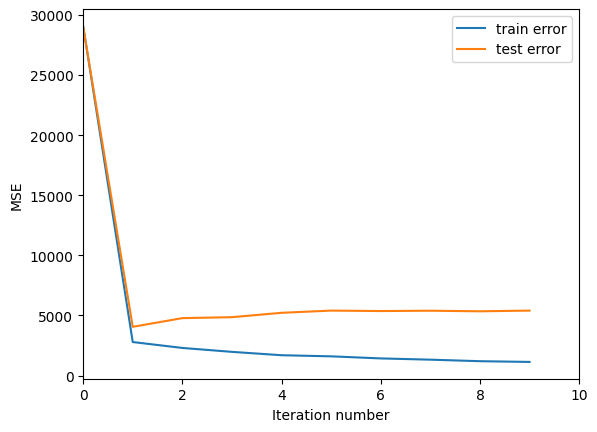

In [13]:
get_error_plot(n_trees, train_errors, test_errors)

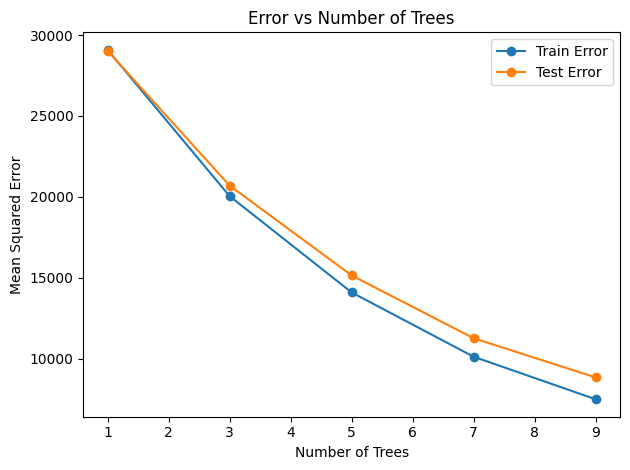

In [14]:
n_trees_list = [1, 3, 5, 7, 9]

train_errors_trees = []
test_errors_trees = []

for n_trees in n_trees_list:
    _, train_errors, test_errors = gb_fit(n_trees, max_depth=3, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, eta=0.1)
    train_errors_trees.append(train_errors[-1])
    test_errors_trees.append(test_errors[-1])

plt.plot(n_trees_list, train_errors_trees, label="Train Error", marker='o')
plt.plot(n_trees_list, test_errors_trees, label="Test Error", marker='o')
plt.xlabel("Number of Trees")
plt.ylabel("Mean Squared Error")
plt.title("Error vs Number of Trees")
plt.legend()

plt.tight_layout()
plt.show()

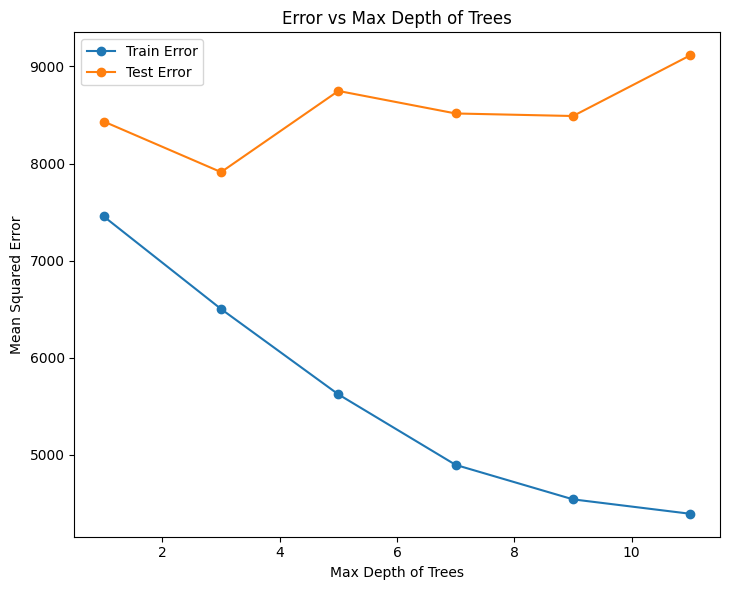

In [15]:
max_depth_list = [1, 3, 5, 7, 9, 11]

train_errors_depth = []
test_errors_depth = []

for max_depth in max_depth_list:
    _, train_errors, test_errors = gb_fit(n_trees=10, max_depth=max_depth, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, eta=0.1)
    train_errors_depth.append(train_errors[-1])
    test_errors_depth.append(test_errors[-1])

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 2)
plt.plot(max_depth_list, train_errors_depth, label="Train Error", marker='o')
plt.plot(max_depth_list, test_errors_depth, label="Test Error", marker='o')
plt.xlabel("Max Depth of Trees")
plt.ylabel("Mean Squared Error")
plt.title("Error vs Max Depth of Trees")
plt.legend()

plt.tight_layout()
plt.show()

## Задание 2

Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [16]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

def gb_fit_sgd(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    trees = []
    train_errors = []
    test_errors = []

    n_samples = X_train.shape[0]  # Количество обучающих примеров
    batch_size = int(n_samples * 0.5)  # Размер подвыборки (50% от обучающей выборки)

    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)  # Создание нового дерева

        if len(trees) == 0:
            # Если это первое дерево, обучаем его на всех данных
            tree.fit(X_train, y_train)
        else:
            # Прогнозируем текущие значения с помощью уже обученных деревьев
            target = gb_predict(X_train, trees, eta)
            residuals = residual(y_train, target)  # Вычисляем остатки

            # Выбираем случайную подвыборку для обучения дерева
            indices = np.random.choice(n_samples, size=batch_size, replace=False)
            X_batch = X_train[indices]
            y_batch = residuals[indices]

            # Обучаем дерево на выбранной подвыборке остатков
            tree.fit(X_batch, y_batch)

        trees.append(tree)  # Добавляем дерево в список

        # Вычисляем ошибки на обучающей и тестовой выборках
        train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
        test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

    return trees, train_errors, test_errors

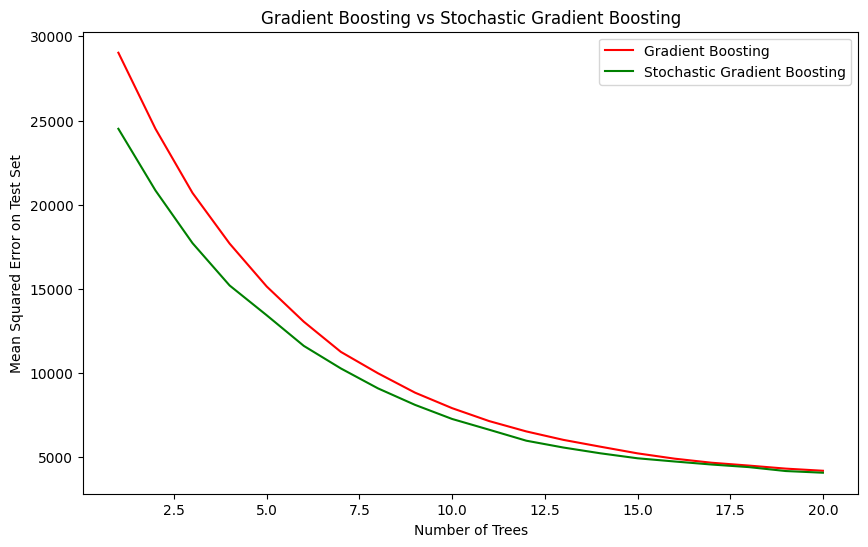

In [17]:
n_trees = 20
max_depth = 3
eta = 0.1

_, _, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
_, _, test_errors_sgd = gb_fit_sgd(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_trees + 1), test_errors, label="Gradient Boosting", color="red")
plt.plot(range(1, n_trees + 1), test_errors_sgd, label="Stochastic Gradient Boosting", color="green")
plt.xlabel("Number of Trees")
plt.ylabel("Mean Squared Error on Test Set")
plt.title("Gradient Boosting vs Stochastic Gradient Boosting")
plt.legend()
plt.show()

## Задание 3

Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени.

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

def gb_fit_opti(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    trees = []
    train_errors = []
    test_errors = []

    current_predictions = np.zeros(y_train.shape)  # Инициализация текущих предсказаний нулями

    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)  # Создание нового дерева

        residuals = y_train - current_predictions  # Вычисляем остатки как разницу между истинными значениями и текущими предсказаниями
        tree.fit(X_train, residuals)  # Обучаем дерево на остатках

        trees.append(tree)  # Добавляем дерево в список

        current_predictions += eta * tree.predict(X_train)  # Обновляем текущие предсказания с учетом нового дерева

        # Вычисляем ошибки после добавления нового дерева
        train_error = mean_squared_error(y_train, current_predictions)
        test_error = mean_squared_error(y_test, gb_predict(X_test, trees, eta))

        train_errors.append(train_error)
        test_errors.append(test_error)

    return trees, train_errors, test_errors

In [19]:
%%time
n_trees = 10
max_depth = 3
eta = 0.1

trees1, train_errors1, test_errors1 = gb_fit_opti(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

CPU times: user 741 ms, sys: 7.93 ms, total: 749 ms
Wall time: 746 ms


In [20]:
%%time

n_trees = 10
max_depth = 3
eta = 0.1

trees2, train_errors2, test_errors2 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

CPU times: user 4.53 s, sys: 169 ms, total: 4.7 s
Wall time: 4.61 s


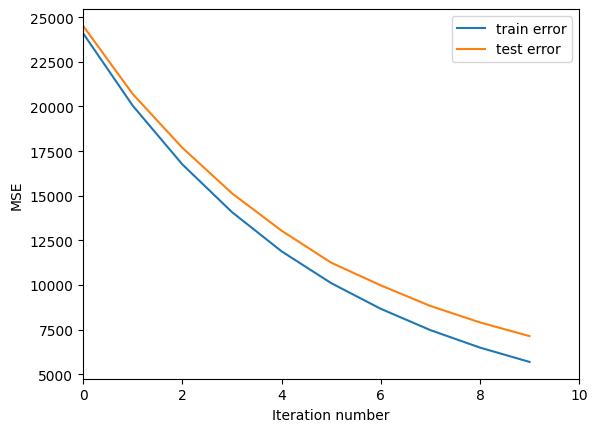

In [21]:
get_error_plot(n_trees, train_errors1, test_errors1)

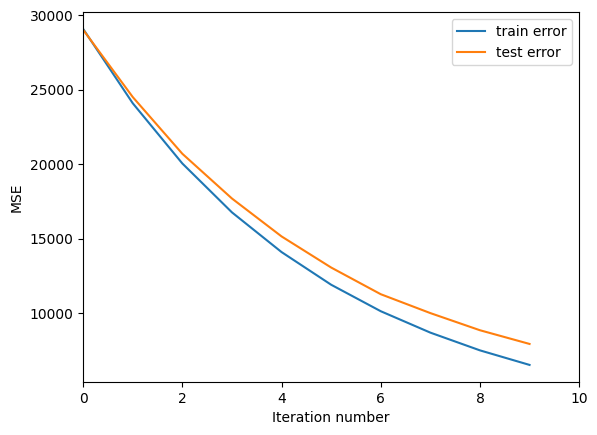

In [22]:
get_error_plot(n_trees, train_errors2, test_errors2)